# Taweret: Multivariate Model Mixing Tutorial

## Author: Alexandra Semposki

### Date: 26 June 2023

---

Welcome to the FRIB summer school hands-on session with our Bayesian Model Mixing (BMM) package, Taweret! Below we'll look at an interesting toy model that we can apply one of Taweret's many BMM methods to. We'll have short tasks for you along the way so that you can get accustomed to the package and to BMM generally.  

---

Further reading:

*Bayesian data analysis and statistics*

- A. Gelman, J. Carlin, H. Stern, D. Dunson, A. Vehtari, D. Rubin. "Bayesian Data Analysis", 1995. http://www.stat.columbia.edu/~gelman/book/.
- J. S. Sivia, "Data Analysis: A Bayesian Tutorial", Oxford University Press, 2nd Ed., 2006. 

*Gaussian Processes*

- J. A. Melendez, R. J. Furnstahl, D. R. Phillips, M. T. Pratola, and S. Wesolowski, Quantifying Correlated Truncation Errors in Effective Field Theory, Phys. Rev. C 100, 044001 (2019), arXiv:1904.10581 [nucl-th].
- Carl Edward Rasmussen and Christopher K. I. Williams, "Gaussian Processes for Machine Learning", The MIT Press, 2006.

---
---

Below we define the models for our Bayesian Model Mixing exercise. The workflow for this hands-on tutorial is as follows:

1). __Define__ the models;

2). __Plot__ the models' means and standard deviations as uncertainty bands;

3). Apply __BMM__ via the `Multivariate` method in Taweret;

4). Plot the __posterior predictive distribution__ obtained from the model mixing;

5). Examine the __weights__ of each individual model when compiled into the mixed model. 

---
---

Our learning objectives include:
- Understanding the toy model case used below;
- Learning how to apply Multivariate Model Mixing using Taweret;
- Developing a GP model and applying it to this toy model;
- Interpreting the results of the final mixed model

## Defining our models

Now, let's start by looking at the models that we'll be using. We want to mix the expansions of the zero-dimensional $\phi^4$-theory partition function, below:

$$
 F(g) = \int_{-\infty}^{\infty} dx~ e^{-\frac{x^{2}}{2} - g^{2} x^{4}} = \frac{e^{\frac{1}{32 g^{2}}}}{2 \sqrt{2}g} K_{\frac{1}{4}}\left(\frac{1}{32 g^{2}} \right).
$$

The two expansions are limits taken at $g = 0$ and $g = \infty$:

$$
F_{s}^{N_s}(g) = \sum_{k=0}^{N_{s}} s_{k} g^{k},
$$

and 

$$
F_{l}^{N_{l}}(g) = \frac{1}{\sqrt{g}} \sum_{k=0}^{N_{l}} l_{k} g^{-k},
$$

with coefficients given as:

$$
s_{2k} = \frac{\sqrt{2} \Gamma{(2k + 1/2)}}{k!} (-4)^{k},~~~~~s_{2k + 1} = 0
$$

and

$$
l_{k} = \frac{\Gamma{\left(\frac{k}{2} + \frac{1}{4}\right)}}{2k!} \left(-\frac{1}{2}\right)^{k}.
$$

Notice that $F_{s}^{N_{s}}(g)$ is an asymptotic series---the more terms we add to the series expansion, the more it diverges from the true solution. Hence, its radius of convergence is zero. However, $F_{l}^{N_{l}}(g)$ is a convergent series, hence its radius of convergence is $\infty$, and we see in the plot that, with more orders added, we converge more and more with the true solution.

__Checkpoint__: Click on the following link and scroll down on the README page to see an animated plot of different truncation orders!

https://github.com/asemposki/SAMBA/tree/Development

We begin by importing all of the Python packages we will need in this Jupyter notebook.

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import math
import sys
import os
import statistics
from cycler import cycler
from scipy import stats, special, integrate

# install a couple of needed packages for SAMBA
!pip install emcee
!pip install corner

!pip install latex

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline

#matplotlib settings for Latex plots
import matplotlib
matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': False,
})

Now we pull in the Taweret package and the models it contains. Below we import from Taweret the __BaseModel__ and __BaseMixer__ classes, which we discussed during the first part of the session. They are the base classes on which Taweret operates, and which allow the user to define models and mixing strategies of their own!

We are also importing from the `samba_models` file, which contains the toy model we're using. 

After we clone in Taweret, we'll need to clone in SAMBA for the (optional!) GP section of the notebook.

In [3]:
# Clone the Taweret Repo
!git clone https://github.com/asemposki/Taweret.git 
!cd Taweret && git checkout develop

fatal: destination path 'Taweret' already exists and is not an empty directory.
Already on 'develop'
Your branch is up to date with 'origin/develop'.


In [4]:
# Clone the SAMBA repo
!git clone https://github.com/asemposki/SAMBA.git
!cd SAMBA && git checkout Development

fatal: destination path 'SAMBA' already exists and is not an empty directory.
Already on 'Development'
Your branch is up to date with 'origin/Development'.


In [5]:
from Taweret.Taweret.core.base_model import BaseModel
from Taweret.Taweret.core.base_mixer import BaseMixer

from Taweret.Taweret.models import samba_models  # problem right here
from SAMBA.samba.gaussprocess import GP

## Plotting our models

Now we plot the functions we want to mix to see what they look like. We need to first pick a value for $N_{s}$ and $N_{l}$. Let's pick $N_{s}$ = 3 and $N_{l}$ = 3, which means we truncate our series expansions after the third term in each. Our uncertainties are then $\mathcal{O}(g^{4})$.

We must also define the range of our input parameter (coupling constant), $g$.

In [6]:
#define g and orders of the series expansions
g = np.linspace(1e-6,1.0,100)
N_s = 3
N_l = 4

To plot our models and their uncertainties, we look at what functions are available to us in the `samba_models` file. __Uncomment the cell below and run it. What functions are contained in the file?__

In [7]:
help(samba_models)

Help on module Taweret.Taweret.models.samba_models in Taweret.Taweret.models:

NAME
    Taweret.Taweret.models.samba_models

DESCRIPTION
    # This toy example is copied from Alexandra; SAMBA package
    # : \phi^4 expansion for small and large g :

CLASSES
    Taweret.Taweret.core.base_model.BaseModel(abc.ABC)
        exp_data
        highorder
        loworder
        true_model
    
    class exp_data(Taweret.Taweret.core.base_model.BaseModel)
     |  A wrapper for SAMBA data function
     |  
     |  Method resolution order:
     |      exp_data
     |      Taweret.Taweret.core.base_model.BaseModel
     |      abc.ABC
     |      builtins.object
     |  
     |  Methods defined here:
     |  
     |  evaluate(self, input_values: <built-in function array>, error=0.01) -> <built-in function array>
     |      Evaluate the mean and error for given input values
     |      
     |      Parameters
     |      ----------
     |      input_values : numpy 1darray
     |          coupling s

We will first make a `dict` of models and then plot them, calling the classes listed in the `help` information above.

In [8]:
# call the 'loworder' class to generate the small-g expansion model given N_s
model_1 = samba_models.loworder(N_s, error_model='informative')

# call the 'highorder' class to generate the large-g expansion model given N_l
model_2 = samba_models.highorder(N_l, error_model='informative')

model_3 = samba_models.loworder(10, error_model='informative')

In [9]:
# define the dictionary of models
my_models = {
    "1" : model_1,
    "2" : model_2,
    "3" : model_3
}

This is great, but how do we *plot* the models using the linspace in $g$ that we specified earlier? We use the function `evaluate`, located in each of the models' classes above.

In [10]:
help(samba_models.loworder.evaluate)

Help on function evaluate in module Taweret.Taweret.models.samba_models:

evaluate(self, input_values: <built-in function array>) -> <built-in function array>
    Evaluate the mean and error for given input values
    
    Parameters
    ----------
    input_values : numpy 1darray
        coupling strength (g) values
    
    Returns:
    --------
    mean : numpy 1darray
        The mean of the model
    np.sqrt(var) : numpy 1darray
        The truncation error of the model



__Checkpoint__: Uncomment the cell above and run it. What two outputs does the `evaluate` function return?

Let's evaluate both of our models from the `dict` above, and plot them. 

In [11]:
# evaluate the two models
model_results = []

for i in my_models.keys():
    model_results.append(my_models[i].evaluate(g))

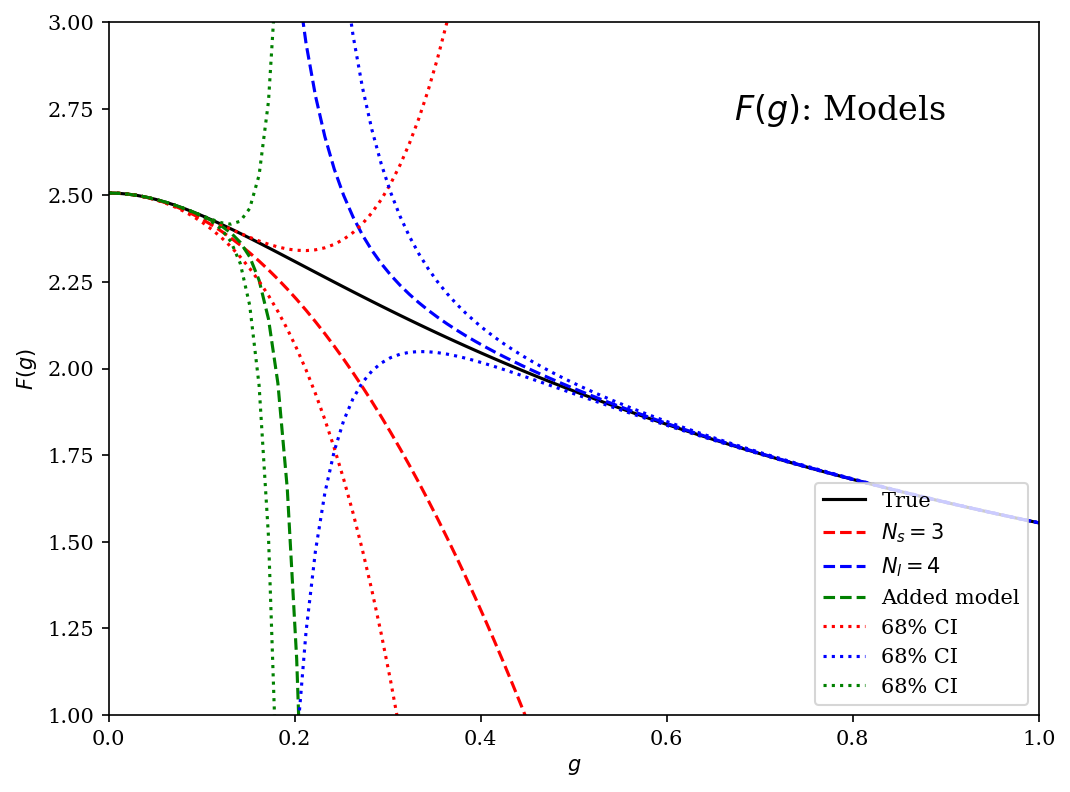

In [12]:
# plot the models
fig = plt.figure(figsize=(8,6), dpi=150)
ax = plt.axes()
ax.set_xlim(0.0,1.0)
ax.set_ylim(1.0,3.0)
ax.text(0.9,0.9, r'$F(g)$: Models', ha='right', va='top',
        transform=ax.transAxes, fontsize=16)
ax.set_xlabel(r'$g$')
ax.set_ylabel(r'$F(g)$')

# color scheme
colors = ['red', 'blue', 'green', 'orange']

# labels
labels = [r'$N_s = {}$'.format(N_s), r'$N_l = {}$'.format(N_l), r'Added model']
unc_labels = [r'68% CI', r'68% CI', r'68% CI']

# lines
lines = ['dashed', 'dotted']

# plot the true model
ax.plot(g, samba_models.true_model().evaluate(g)[0].flatten(), color='k', label='True')

# model means
for i in range(len(model_results)):
      ax.plot(g, model_results[i][0].flatten(), color=colors[i], linestyle=lines[0], label=labels[i])
        
# model uncertainties
for i in range(len(model_results)):
    ax.plot(g, model_results[i][0].flatten() - model_results[i][1].flatten(), color=colors[i], linestyle=lines[1], label=unc_labels[i])
    ax.plot(g, model_results[i][0].flatten() + model_results[i][1].flatten(), color=colors[i], linestyle=lines[1])
    
# legend
ax.legend(loc='lower right')
plt.show()

__Checkpoint__: What do the dotted curves above represent? 

Now we need a way to estimate the truncation error from the excluded terms in the series expansions. 

We can consider that we may have some intuition, based on the coefficients we do know, for those at higher orders that we do not possess. As we know that the small-$g$ expansion above (in red) is an asymptotic series, and that the large-$g$ expansion (in blue) is a converging Taylor series, we could form coefficients that follow the series' expansion parameters like so:

$$
\begin{equation}
\sigma_{N_s}(g)=\left\{ \begin{array}{lc}
	\Gamma(N_s/2+1) (4g)^{N_s + 2} \bar{c}, & \mbox{if $N_s$ is even;}\\
    \Gamma(N_s/2+1/2) (4g)^{N_s+1} \bar{c}, & \mbox{if $N_s$ is odd,}
    \end{array} \right. 
\end{equation}
$$

for the small-$g$ expansion, and 

$$
\begin{equation}
\sigma_{N_l}(g)=\left(\frac{1}{4g}\right)^{N_l + 3/2} \frac{1}{\Gamma(N_l/2+3/2)} \bar{d},
\end{equation}
$$

for the large-$g$ expansion. We could also assume that we know very little, and come up with a model that is even less informative than this one. The informative example above, however, is the one that we have set as a default in the models used in Taweret (this of course can be changed if you wish!).

For all of the nitty gritty details, see Appendix B of [our paper](https://arxiv.org/abs/2206.04116).

## Part I: Bivariate Mixing

To mix our models, we form Gaussian distributions first from $F_{s}(g)$ and $F_{l}(g)$:

$$
\mathcal{M}_{s} = \mathcal{N}(F_{s}(g), \sigma^{2}_{s}(g)), \quad
\mathcal{M}_{l} = \mathcal{N}(F_{l}(g), \sigma^{2}_{l}(g)).
$$

From here, we can actually simply mix these two models together! Using Taweret, we can call the model mixing scheme that will mix the two models using the bivariate model mixing method, where we combine the two models' means and variances like so:

$$
f^{\dagger} \sim \bigl(Z_P^{-1}\sum_k \frac{1}{v_k}f_k, Z_P^{-1}\bigr),
$$

where 

$$
Z_P \equiv \sum_{k=1}^{K}\frac{1}{v_k}.
$$

$Z_P$ is the precision, or the inverse of the variance, of the $K$ models, $v_{k}$ the individual variances of each model (which we previously denoted the theory error), and $f^{\dagger}$ the mixed model.

To mix these models together, we need to instantiate the `Multivariate` class in Taweret.

In [13]:
from Taweret.Taweret.mix.gaussian import Multivariate

__Checkpoint__: Look over the `Multivariate` class using the commented help cell below. What functions does it contain? What do they do?

In [14]:
help(Multivariate)

Help on class Multivariate in module Taweret.Taweret.mix.gaussian:

class Multivariate(Taweret.Taweret.core.base_mixer.BaseMixer)
 |  Multivariate(x, models, n_models=0)
 |  
 |  The multivariate BMM class originally introduced
 |  in the BAND SAMBA package. Combines individual
 |  models using a Gaussian form. 
 |  
 |  .. math::
 |  
 |      f_{\dagger}
 |      = \mathcal{N}
 |      \left(
 |          \sum_i \frac{f_i/v_i}{1/v_i}, \sum_i \frac{1}{v_i}
 |      \right)
 |  
 |  Example:
 |  --------
 |  
 |  .. code-block:: python
 |  
 |          m = Multivariate(x=np.linspace(), models=dict(), n_models=0)
 |          m.predict(ci=68)
 |          m.evaluate_weights()
 |  
 |  Method resolution order:
 |      Multivariate
 |      Taweret.Taweret.core.base_mixer.BaseMixer
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, x, models, n_models=0)
 |      Parameters:
 |      -----------
 |      x : numpy.linspace
 |          Input space variable 

In [15]:
# call Multivariate
biv_model = Multivariate(g, my_models, n_models=len(my_models))

Now we simply use the `predict` function in the `Multivariate` class to produce the mixed model with its mean and uncertainties. We can plot this result below. 

__Checkpoint__: Uncomment the cell below and run it. What inputs and outputs does `Multivariate.predict` have?

In [16]:
help(Multivariate.predict)

Help on function predict in module Taweret.Taweret.mix.gaussian:

predict(self, ci=68)
    The f_dagger function responsible for mixing the models together
    in a Gaussian way. Based on the first two moments of the
    distribution: mean and variance.
    
    Parameters:
    -----------
    ci : int, list
        The desired credibility interval(s) (1-sigma, 2-sigma) 
    
    Returns:
    --------
    mean, intervals, std_dev : The mean, credible intervals, and std_dev 
                           of the predicted mixed model



In [17]:
# call predict
_, biv_mean, biv_intervals, biv_std_dev = biv_model.predict(ci=68)

Now we plot the mixed model!

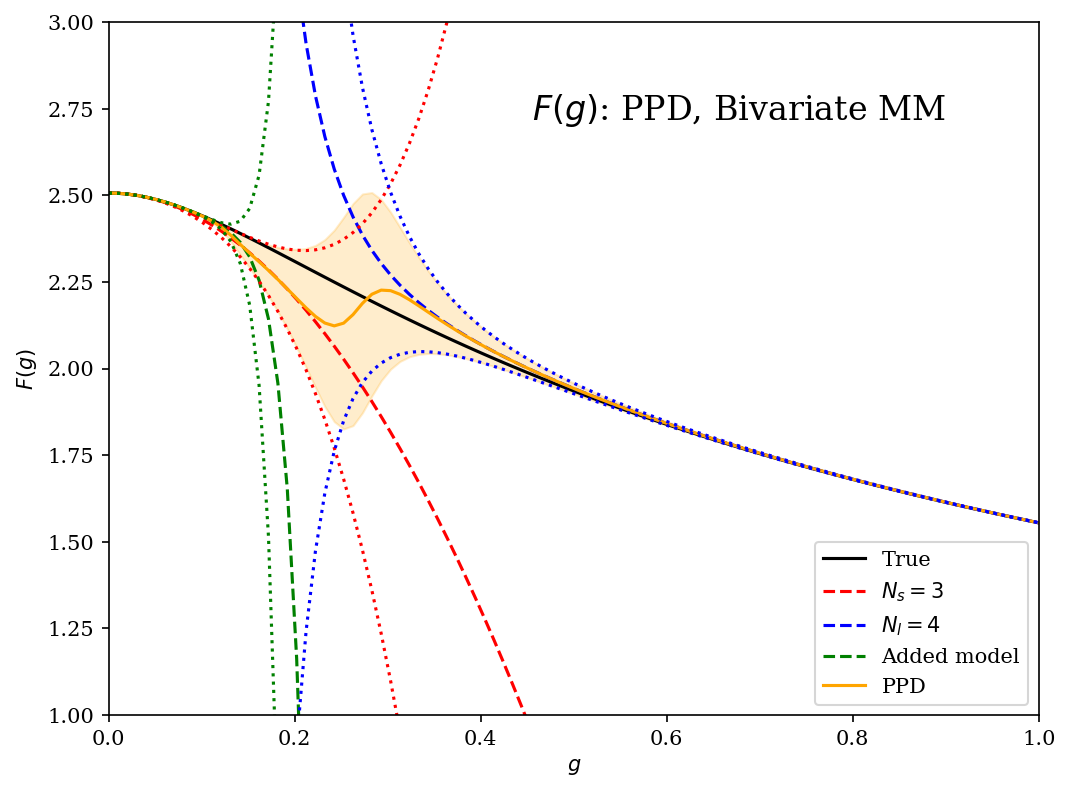

In [18]:
# plot the mixed model
fig = plt.figure(figsize=(8,6), dpi=150)
ax = plt.axes()
ax.set_xlim(0.0,1.0)
ax.set_ylim(1.0,3.0)
ax.text(0.9,0.9, r'$F(g)$: PPD, Bivariate MM', ha='right', va='top',
        transform=ax.transAxes, fontsize=16)
ax.set_xlabel(r'$g$')
ax.set_ylabel(r'$F(g)$')
ax.plot(g, samba_models.true_model().evaluate(g)[0].flatten(), color='k', label='True')

# model means
for i in range(len(model_results)):
      ax.plot(g, model_results[i][0].flatten(), color=colors[i], linestyle=lines[0], label=labels[i])

# PPD mean
ax.plot(g, biv_mean, color=colors[3], label='PPD')
        
# model uncertainties
for i in range(len(model_results)):
    ax.plot(g, model_results[i][0].flatten() - model_results[i][1].flatten(), color=colors[i], linestyle=lines[1])
    ax.plot(g, model_results[i][0].flatten() + model_results[i][1].flatten(), color=colors[i], linestyle=lines[1])
    
# PPD band
ax.fill_between(g, biv_mean-biv_std_dev, biv_mean+biv_std_dev,
                        zorder=i-5, facecolor=colors[3], edgecolor=colors[3], alpha=0.2)

# legend
ax.legend(loc='lower right')
plt.show()

And, as simple as that, there is the mixed model! The green curve is the PPD from the $f^{\dagger}$ equation previously discussed. 

__Question__: Discuss with your neighbour whether you think that the uncertainty band in the ''gap'' of the mixed model plot is too large, too small, or reasonable. Speculate on how, in a real-world scenario where the true model was *not* a known quantity, you might know this?

### Weights: bivariate MM

Now we'd like to look at what the location-dependent weights show us. What are the __weights__ of the models? These are simply the inverse of their variances (the precision, to be precise). These weights show which model dominates in which region of the input space, and they do so point-by-point, having been calculated at each chosen point in the input space. They are plotted below for the two models above.

__Exercise__: Fill in the code to evaluate the weights by calling the necessary function from the `Multivariate` class.

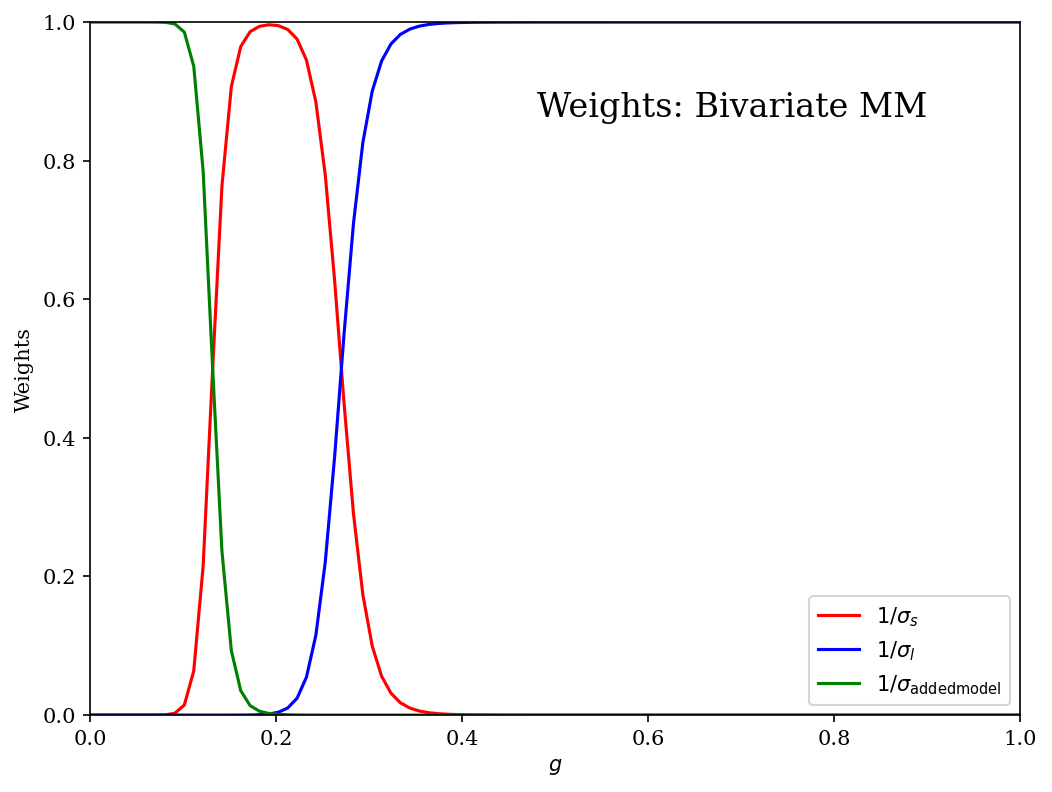

In [19]:
# call the evaluate_weights function
biv_weights = biv_model.evaluate_weights()

labels_weights = [r'$1/\sigma_{s}$', r'$1/\sigma_{l}$', r'$1/\sigma_{ {\rm added model}}$']

# plot the weights
fig = plt.figure(figsize=(8,6), dpi=150)
ax = plt.axes()
ax.set_xlim(0.0,1.0)
ax.set_ylim(0.0,1.0)
ax.text(0.9,0.9, 'Weights: Bivariate MM', ha='right', va='top',
        transform=ax.transAxes, fontsize=16)
ax.set_xlabel(r'$g$')
ax.set_ylabel('Weights')

# model weights
for i in range(len(biv_weights)):
    ax.plot(g, biv_weights[i], color=colors[i], label=labels_weights[i])

# legend
ax.legend(loc='lower right')
plt.show()

__Questions__: What do the weights above tell you? Do these results make sense, based what you know about which model is dominant in each region?

---

## Challenge questions for Part I

As previously mentioned, the mixed model result for the two toy models above could use some thought, and perhaps, some improvement.

__Questions for you to think about and explore__:

1). What do you think would happen if you instead used a different truncation order for $N_{l}$? Try using $N_{l} = 6$ and see what happens. How does the mean of the mixed model change? How do the weights change for this new order?

2). __Challenge exercise__: Try adding another model to the mix in the `my_models` dictionary. You can add either a small-$g$ (`loworder`) or large-$g$ (`highorder`) model. (Taweret is currently capable of handling $N$ models when using this mixing technique!) What happens to the mixed model mean, uncertainty, and the weights of each model when you do this?

---
---

## Part II: Multivariate Model Mixing: Adding a GP

We'd like to improve our results above, so we will employ a __Gaussian Process__. Gaussian processes are non-parametric emulators that can be used for interpolation and regression. They possess tunable hyperparameters that we can calibrate to improve the GP fit and predict capabilities. 

Much like a neural network (and in fact it is the limit of one) a GP requires training data to calibrate it, and testing data to predict results at new data points. Their form consists of a mean function, $m(x)$, and a covariance function, $\kappa(x,x')$. Usually the mean function is taken to be zero, though that can be altered if needed. The covariance function is usually a function of the Euclidean distance between the points $x$ and $x'$, which we term __stationary kernels__ of our GP. (As you can probably imagine, a covariance function that does *not* depend on |$x-x'$| but instead on $x$ is a __non-stationary kernel__, but we don't need to worry about these *here*.) From the name, the covariance function is the crucial component of the GP that captures correlations in the data, and must be positive semi-definite. We can mathematically write a GP down as

$$
\textbf{f}|\textbf{x} = \mathcal{N}(\textbf{m}, \textit{K}),
$$
where $\textbf{m} = m(\textbf{x})$ and $\textit{K} = \kappa(\textbf{x}, \textbf{x}')$, and $\textbf{f}$ is a training set of data corresponding to training points $\textbf{x}$.

Here, we employ the well-known Python package `scikit-learn`, which allows the user the pick from multiple forms of the covariance function to set the __prior__ of the GP. Let's look at some of the options there.

In [20]:
# import scikit learn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import kernels

# show the options for kernels by uncommenting and running the line below
help(kernels)

Help on module sklearn.gaussian_process.kernels in sklearn.gaussian_process:

NAME
    sklearn.gaussian_process.kernels - Kernels for Gaussian process regression and classification.

DESCRIPTION
    The kernels in this module allow kernel-engineering, i.e., they can be
    combined via the "+" and "*" operators or be exponentiated with a scalar
    via "**". These sum and product expressions can also contain scalar values,
    which are automatically converted to a constant kernel.
    
    All kernels allow (analytic) gradient-based hyperparameter optimization.
    The space of hyperparameters can be specified by giving lower und upper
    boundaries for the value of each hyperparameter (the search space is thus
    rectangular). Instead of specifying bounds, hyperparameters can also be
    declared to be "fixed", which causes these hyperparameters to be excluded from
    optimization.

CLASSES
    builtins.object
        GenericKernelMixin
        Kernel
            CompoundKernel
  

Looking above through the `help` information, we can spot the types of stationary kernels scikit-learn can call and implement: 
- ConstantKernel
- RBF
- ExpSineSquared
- RationalQuadratic
- Matern
- WhiteKernel

Let's pull some samples from one of them to see what the form of the kernel looks like. 

In [25]:
print(samples)

[[-2.24799654 -0.56782329 -0.78027008 ... -1.34647787 -1.80861636
  -0.45861422]
 [-2.24050597 -0.56895272 -0.78207515 ... -1.34414938 -1.80960329
  -0.45991991]
 [-2.23299854 -0.57001473 -0.78387071 ... -1.34180282 -1.81052818
  -0.46124565]
 ...
 [-0.9115263  -0.72944658  0.44534063 ...  1.2130249   1.09243752
  -0.79708329]
 [-0.90832948 -0.73131869  0.44689211 ...  1.2198057   1.10007517
  -0.79514065]
 [-0.90517947 -0.73316124  0.44839446 ...  1.22653906  1.10772261
  -0.79319387]]


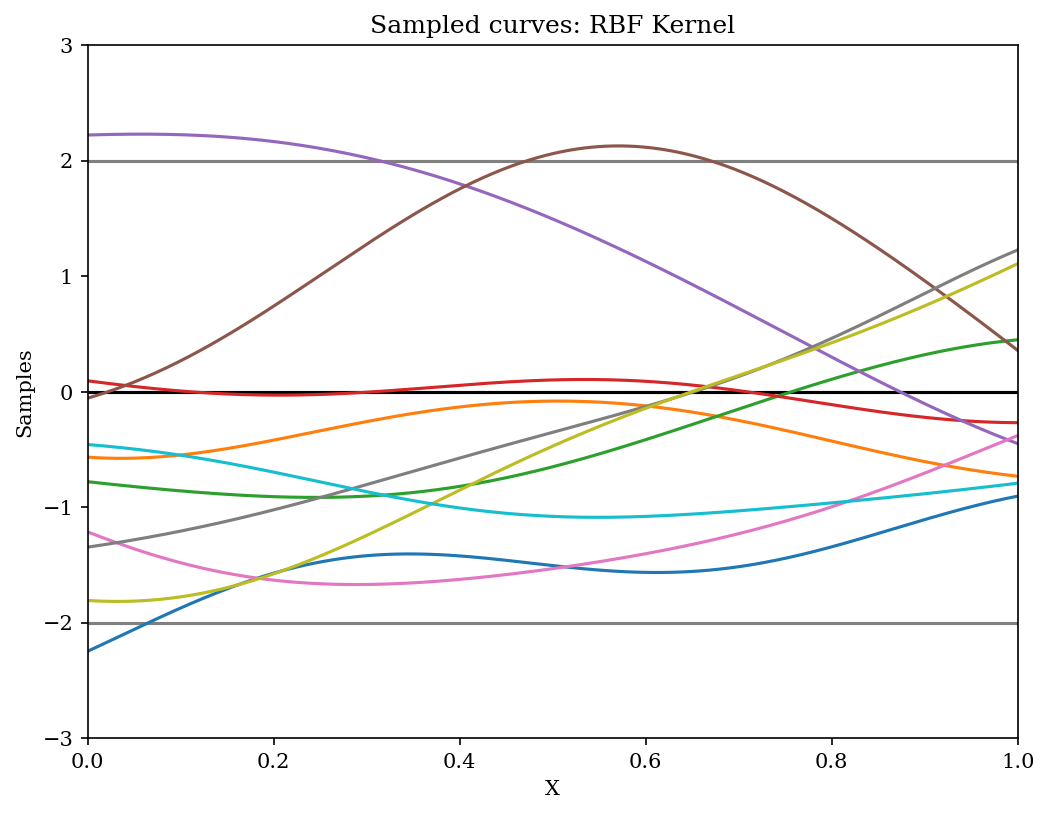

In [26]:
# set up the RBF kernel and GP object
kern = kernels.RBF(length_scale=0.4)
gpr = GaussianProcessRegressor(kern)

x = np.linspace(0.0,1.0,500)
X = x[:,None]

# sample from the prior (kernel)
n_samples = 10
samples = gpr.sample_y(X, n_samples=n_samples)

# plot these samples
fig = plt.figure(figsize=(8,6), dpi=150)
ax = plt.axes()
ax.set_xlabel('X')
ax.set_ylabel('Samples')
ax.set_xlim(0.0,1.0)
ax.set_ylim(-3.0,3.0)
ax.set_title('Sampled curves: RBF Kernel')
    
# plot the mean and variance levels
ax.axhline(y=0, color='k')
ax.axhline(y=2, color='grey')
ax.axhline(y=-2, color='grey')

# plot the samples
for i in range(n_samples):
    plt.plot(x,samples[:,i])

The grey lines correspond to the 2$\sigma$ variance level, and the mean function is at y = 0 (black line). From this sampling, we can see that the curves from the RBF kernel are very smooth---*too* smooth, in fact, for some applications, as we'll see later on.

__Exercise__: Try sampling curves from the Matern 3/2 kernel instead. What do the curves look like? How are they different from those sampled from the RBF kernel?

Now, let's try to use one of these vanilla GPs to interpolate between the two models in the toy case, and see how our results change. Why would we want to do this? Because GPs can be used to build in important physics and constraints on the system, which would be very useful in a real-world application---*especially* in regions where we may not have much data.

How do we include the GP as another model in the mixing strategy? We simply use the formula defined at the top of this notebook, which we copy here again:

$$
f^{\dagger} \sim \bigl(Z_P^{-1}\sum_k \frac{1}{v_k}f_k, Z_P^{-1}\bigr),
$$

where 

$$
Z_P \equiv \sum_{k=1}^{K}\frac{1}{v_k}.
$$

$Z_P$ is the precision, or the inverse of the variance, of the $K$ models, $v_{k}$ the individual variances of each model (which we previously denoted the theory error), and $f^{\dagger}$ the mixed model. For our specific case, $K=3$ now, since we're including the GP as a third model.

---

### Writing a model class for the GP

Now it's your turn to shine! In this section, you'll see a lot of empty code blocks---__you__ get to fill those in and develop the model wrapper class for the GP model. 

To use a GP as a third model, we need to instantiate a model class that includes the GP and conforms to the necessary `BaseModel` requirements. You'll start by filling in the `__init__` function to call the GP class developed in the package `SAMBA` which has been loaded into this notebook. The GP we have will be instantiated in the `__init__` function, and the `evaluate` function will train, test, and output results from the GP in the form of the model mean and variance.  

*Hint for building the `evaluate` function: Ignore the static methods at the bottom of the help information and focus on the class functions at the top. Which of these are necessary to implement a GP given training and testing data?*

__Bonus information on GPs__:
In `scikit-learn`, GPs are instantiated via the `GaussianProcessRegressor` class. It takes the arguments `kernel`, which we already know, `n_restarts_optimizer`, which indicates how many different starting points to use when optimizing the hyperparameters, and `normalize_y`, a Boolean variable that determines whether $m(x)$ (the mean function) is zero or the mean of the data set we use. All of this is wrapped below in the GPModel class. If you would like to play with these parameters, or just look at how we formulate this GP code in more detail, check out the SAMBA package we're wrapping below [here](https://github.com/asemposki/SAMBA).

In [27]:
# uncomment and run this cell to see the SAMBA GP options
help(GP)

Help on class GP in module SAMBA.samba.gaussprocess:

class GP(SAMBA.samba.discrepancy.Bivariate)
 |  GP(g, loworder, highorder, kernel='RBF', nu=None, ci=68, error_model='informative')
 |  
 |  Method resolution order:
 |      GP
 |      SAMBA.samba.discrepancy.Bivariate
 |      SAMBA.samba.models.Models
 |      SAMBA.samba.models.Uncertainties
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  MD_set(self, pts=3, plot=False)
 |      Takes the training set of points and uses them to cut the
 |      testing set to their limits. This reduces the MD calculation
 |      to the region of interest.  
 |      
 |      Example:
 |          GP.MD_set()
 |      
 |      Parameters:
 |      -----------
 |      pts : int
 |          The number of points to use to calculate the Mahalanobis
 |          distance. Can be any number up to the size of self.gpredict. 
 |      
 |      plot : bool
 |          The option to plot the MD points across the input space. 
 |          Default is Fa

In [32]:
# begin the model class with an __init__ function that takes
# the kernel and the input space range (see BaseModel for functions needed)
class GPModel: 
    
    # init function sets up the GP
    # nu = value for Matern kernel (root of Bessel function)
    def __init__(self, g, N_s, N_l, kernel='RBF', nu=0, ci=68, \
                 error_model='informative'):
        
        self.g = g    
        self.N_s = N_s
        self.N_l = N_l
        
        # set up the GP class object with our model orders and chosen kernel
        self.gpmodel = GP(g,N_s,N_l,kernel,nu,ci,error_model)
        
        return None
    
    # evaluate function for fitting and predicting
    # call GP functions to train and test your GP and output results
    def evaluate(self, g):
    
        self.training()
        mean, std_dev, cov = self.validate()
        
        return mean, std_dev
    
    # to comply with BaseModel, write the log_likelihood function
    def log_likelihood_elementwise(self):
        return None
    
    # to comply with BaseModel, write the set_prior function
    def set_prior(self):
        return None

Because the toy models we are using vary greatly in the speed with which they approach $\pm \infty$ depending on the truncation orders chosen, we must use a detailed training set generator function that determines where to place the points for the GP to train on without straying too far into the region where we do not know much about the function (the ''gap'' in the middle of the plot from previously). Hence, we're wrapping our code from [our paper](https://arxiv.org/abs/2206.04116) to do this quickly here.

Now we can call the above class and see what happens. Once we do this, we can store the mean and standard deviation from this model in the models `dict` and use Taweret to mix all three of them.

In [34]:
# call the GP model and set the object
gp_model = GPModel(g, N_s, N_l, kernel='Matern', nu=1.5, ci=68)

# redefine the dict of models to include the GP model
my_models = {
    "1" : model_1,
    "2" : model_2,
    "3" : gp_model
}

Finally, we're ready to mix. Use the Taweret `Multivariate` class and its functions to mix the three models!

In [ ]:
# instantiate the Multivariate class
mult_mixed = ### YOUR CODE HERE ###

# obtain the posterior predictive distribution for the mixed model
### YOUR CODE HERE ###

If you've written your `GPModel` class correctly, you should see plots of the training and validation sets when you run the mixed model prediction above, along with the values of the optimized kernel hyperparameters! 

__Note__: The above validation data does NOT have the mixed model included, this just shows the three models separately. We can plot the mixed PPD (posterior predictive distribution) and its credible intervals below. 

__Question__: Turn to your neighbour and tell them whether you think the kernel hyperparameters you obtained look reasonable or not given the toy models you mixed. *If you don't know what the kernel hyperparameters mean, ask!*

Now we plot the mixed model and uncertainty band just as before. __Fill in the code to plot them below.__

In [ ]:
# plot the mixed model including the GP
fig = plt.figure(figsize=(8,6), dpi=150)
ax = plt.axes()
ax.set_xlim(0.0,1.0)
ax.set_ylim(1.0,3.0)
ax.text(0.9,0.9, r'$F(g)$: PPD, Multivariate MM', ha='right', va='top',
        transform=ax.transAxes, fontsize=16)
ax.set_xlabel(r'$g$')
ax.set_ylabel(r'$F(g)$')
ax.plot(g, samba_models.true_model().evaluate(g)[0].flatten(), color='k', label='True')

# model means
for i in range(len(model_results)):
      ax.plot(g, model_results[i][0].flatten(), color=colors[i], linestyle=lines[0], label=labels[i])

# PPD mean
### YOUR CODE HERE ###
        
# model uncertainties
for i in range(len(model_results)):
    ax.plot(g, model_results[i][0].flatten() - model_results[i][1].flatten(), color=colors[i], linestyle=lines[1])
    ax.plot(g, model_results[i][0].flatten() + model_results[i][1].flatten(), color=colors[i], linestyle=lines[1])
    
# PPD band (hint: use fill_between for a cleaner plot)
### YOUR CODE HERE ###

# legend
ax.legend(loc='lower right')
plt.show()

This is excellent! Now we have results for the PPD with a GP as an interpolant model between the two original toy models. We can check out the weights from these models to see what they look like. 

### Weights: including a GP

We use the same procedure as before and call the `evaluate_weights` function from the `Multivariate` Taweret class.

In [ ]:
# call the evaluate_weights function
weights = ### YOUR CODE HERE ### 

labels_weights_mult = [r'$1/\sigma_{s}$', r'$1/\sigma_{l}$', r'$1/\sigma_{GP}$']

# plot the weights
fig = plt.figure(figsize=(8,6), dpi=150)
ax = plt.axes()
ax.set_xlim(0.0,1.0)
ax.set_ylim(0.0,1.0)
ax.text(0.9,0.9, 'Weights: Multivariate MM', ha='right', va='top',
        transform=ax.transAxes, fontsize=16)
ax.set_xlabel(r'$g$')
ax.set_ylabel('Weights')

# model weights
for i in range(len(weights)):
    ax.plot(g, weights[i], color=colors[i], label=labels_weights_mult[i])

# legend
ax.legend(loc='center right')
plt.show()

__Question__: Why do you think there are these giant bumps in the weights when looking at toy model orders of $N_{s} = N_{l} = 3$? Why are the curves not smooth in this regard? *Hint*: we have a pretty dense linspace here that we're using for the validation data and the training data. Following this, why is the large-$g$ model not taking over completely at $g = 1$? 

---

## Part II: Concluding remarks and questions

Now it's time for us to wrap this tutorial up! 

__Some final questions for you to answer:__

1). When using $N_{s} = 3$ and $N_{l} = 3$, you can see that the curves dip down towards $-\infty$. Why does this __not__ affect the result from Taweret? In other words, why does the PPD curve not dip with the models as it did in the previous example (bivariate mixing without a GP)?

2). How does the result change if I use a different kernel than the Matern kernel, say the RBF one we explored earlier? Change the kernel to 'RBF' and see what happens!

3). How does the result look if you change the truncation order of one or both of the models? For example, you can change $N_{s}$ to 5, and $N_{l}$ to 7, or any other desired combination. How do the weights change?

---

Jupyter notebook written by: Alexandra Semposki

SAMBA package written by: Alexandra Semposki

Taweret package written by: Dan Liyanage, Alexandra Semposki, John Yannotty, and Kevin Ingles